# Demographic, Economic & Behavioral Data Analysis and Exploration

## Introduction

<img src='clinton_trump.jpg'/>

In this notebook we analyze a few demographic and social factors for the USA, such as:

* Population
* Electoral Votes
* Fraction of Republicans in 2016
* Fraction of Democrats in 2016
* Amount of Votes
* Amount of Votes for Trump
* Amount of Votes for Hillary
* Education
* Race
* Professional Occupations
* Obesity
* Diabetes
* Health Insurance
* Unemployment

## Imports

In [200]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests as r
import lxml.html as html
import bs4 as bs
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

plt.style.use('ggplot')

import sys
sys.path.append('../../libs/')

import DSF_helpers

init_notebook_mode(connected=True)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Religion per State

### Reading our Dataset

In [201]:
with open(r'data/religions.html', "r") as f:
    page = f.read()
    
tree = html.fromstring(page)
df_religion = pd.read_html('data/religions.html')[0]

### Basic Data Cleaning

In [202]:
df_religion.columns = ['state', 'percentage'] #Define column names
df_religion['state'] = df_religion.state.str.replace(r'[0-9]+\.', '', regex=True) #Clean state names
df_religion['percentage'] = (df_religion['percentage'].str.replace('%', '')).astype(int) / 100 #Convert into decimal
df_religion['code'] = df_religion.state.str.strip().apply(lambda x: DSF_helpers.state_name_to_abrv(x)) #Create Abbrev

In [203]:
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale = True,
        locations = df_religion['code'],
        z = df_religion['percentage'].astype(float),
        locationmode = 'USA-states',
        text = df_religion['code'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "% Religious")
        ) ]

layout = dict(
        title = 'USA Percentage of Religious People per State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

<img src="Religion_USA_Plot.png" />

## Comments

* Southeast states are more religious - the so-called **bible-belt**
* We would expect these areas to be Trump supporters
* On the other hand, southwest and northwest are less religious; Northeast is almost non-religious
* Midwest and mideast are mixed

In [204]:
df_religion.to_csv("usa_religion_per_state.csv")

## Education

### Reading our Dataset

In [205]:
df_education = pd.read_html('https://en.wikipedia.org/wiki/List_of_U.S._states_by_educational_attainment', header=0)[0]
df_education.head()

,State,% High school graduate,Rank,% Bachelor's degree,Rank.1,% Advanced degree,Rank.2
0,Tennessee,93.6%,2.0,29.5%,20.0,9.5%,32.0
1,Minnesota,92.4%,2.0,33.7%,10.0,11.2%,17.0
2,New Hampshire,92.3%,3.0,34.9%,8.0,13.0%,9.0
3,Wyoming,92.3%,3.0,25.7%,40.0,8.6%,40.0
4,Alaska,92.1%,5.0,28.0%,26.0,10.1%,27.0


### Basic Cleaning

In [206]:
df_education['code'] = df_education.State.str.strip().apply(lambda x: DSF_helpers.state_name_to_abrv(x))
df_education['% High school graduate'] = (df_education['% High school graduate'].str.replace('%', '')).astype(float) / 100
df_education["% Bachelor's degree"] = (df_education["% Bachelor's degree"].str.replace('%', '')).astype(float) / 100
df_education['% Advanced degree'] = (df_education['% Advanced degree'].str.replace('%', '')).astype(float) / 100
df_education = df_education.drop(['Rank', 'Rank.1', 'Rank.2'], axis=1)

## Visualization

In [207]:
df_education = df_education.set_index('code')

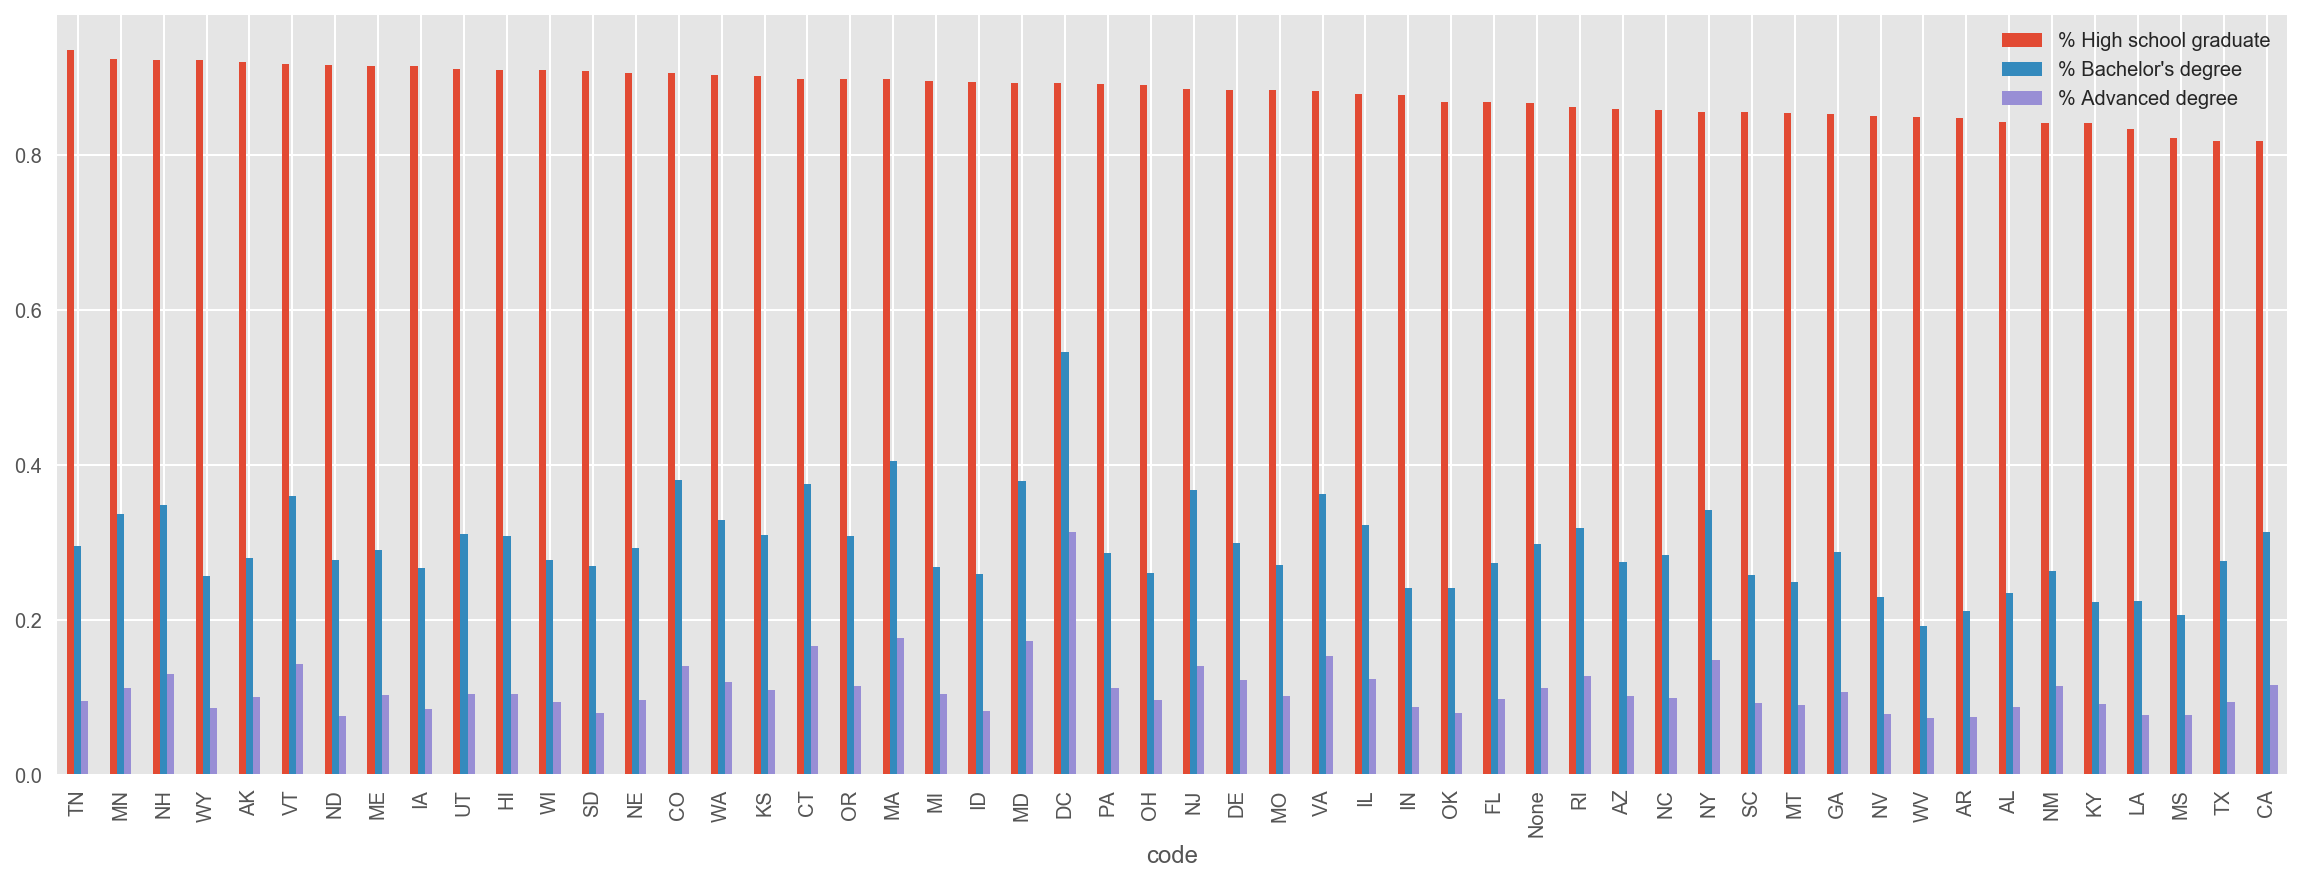

In [208]:
df_education = df_education.dropna()
df_education.plot(kind='bar', legend=True, figsize=(20,7))

In [209]:
df_education = df_education.reset_index()

## Comments

* High school levels are mostly homogeneous across the country
* Bachelor's and Advanced Degrees is more dispersed across the states
* We would expect some correlation between education and religion

## Analyzing Education vs. Religion

In [210]:
df_merged = pd.merge(left=df_religion, right=df_education, on='code').dropna()

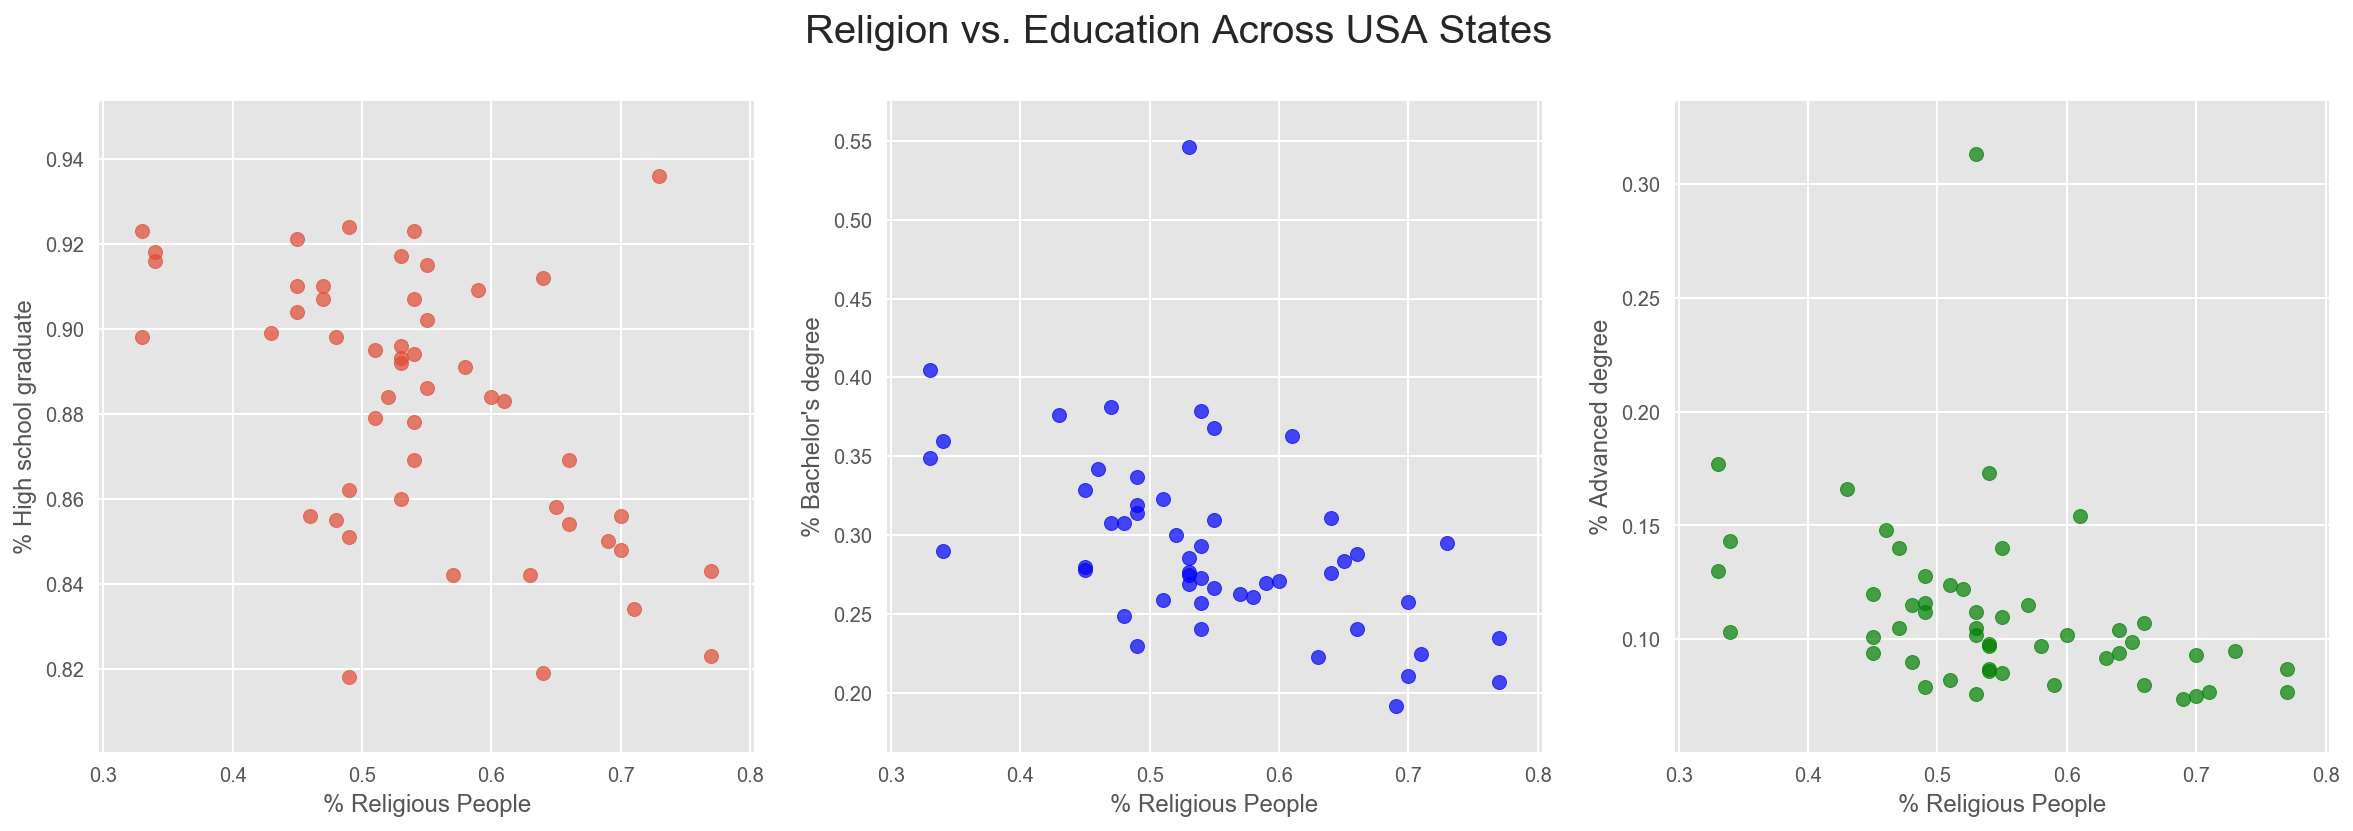

In [211]:
fig, ax = plt.subplots(1,3, figsize=(20,6))

fig.suptitle('Religion vs. Education Across USA States', fontsize=20)

ax[0].scatter(df_merged.percentage, df_merged["% High school graduate"], alpha=0.7)
ax[1].scatter(df_merged.percentage, df_merged["% Bachelor's degree"], alpha=0.7, color='blue')
ax[2].scatter(df_merged.percentage, df_merged["% Advanced degree"], alpha=0.7, color='green')

ax[0].set_xlabel("% Religious People")
ax[1].set_xlabel("% Religious People")
ax[2].set_xlabel("% Religious People")

ax[0].set_ylabel("% High school graduate")
ax[1].set_ylabel("% Bachelor's degree")
ax[2].set_ylabel("% Advanced degree")

In [212]:
df_merged = df_merged.rename(columns={'percentage': 'percentage_religious'})

In [213]:
df_merged.to_csv('dataset_religion_education.csv')

## Unemployment

In [214]:
df_unemployment = pd.read_html('https://www.bls.gov/lau/lastrk16.htm')[0].dropna().reset_index().drop('index', axis=1)
df_unemployment['code'] = df_unemployment['State'].apply(lambda x: DSF_helpers.state_name_to_abrv(x))

In [215]:
df_unemployment.head()

,State,2016rate,Rank,code
0,Hawaii,2.9,1.0,HI
1,New Hampshire,2.9,1.0,NH
2,South Dakota,3.0,3.0,SD
3,Nebraska,3.1,4.0,NE
4,North Dakota,3.1,4.0,ND


In [216]:
df_unemployment = df_unemployment.rename(columns={'2016rate': '2016_unemployment_rate'})

In [217]:
df_merged = pd.merge(df_merged, df_unemployment.loc[:,['code', '2016_unemployment_rate']], on='code')

In [218]:
df_merged.head()

,state,percentage_religious,code,State,% High school graduate,% Bachelor's degree,% Advanced degree,2016_unemployment_rate
0,Alabama,0.77,AL,Alabama,0.843,0.235,0.087,5.9
1,Mississippi,0.77,MS,Mississippi,0.823,0.207,0.077,5.8
2,Tennessee,0.73,TN,Tennessee,0.936,0.295,0.095,4.7
3,Louisiana,0.71,LA,Louisiana,0.834,0.225,0.077,6.0
4,Arkansas,0.70,AR,Arkansas,0.848,0.211,0.075,3.9


## Campaign Rallies

In [219]:
clinton_url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/presidential-campaign-trail/clinton.csv'
trump_url = 'https://raw.githubusercontent.com/fivethirtyeight/data/master/presidential-campaign-trail/trump.csv'

df_clinton_rallies = pd.read_csv(clinton_url)
df_trump_rallies = pd.read_csv(trump_url)

df_clinton_rallies['date'] = pd.to_datetime(df_clinton_rallies['date'])
df_trump_rallies['date'] = pd.to_datetime(df_trump_rallies['date'])

df_clinton_rallies = df_clinton_rallies[df_clinton_rallies.date < '2016-10-01']
df_trump_rallies = df_trump_rallies[df_trump_rallies.date < '2016-10-01']

In [220]:
df_trump_rallies.date.unique()

array(['2016-09-01T00:00:00.000000000', '2016-09-03T00:00:00.000000000',
       '2016-09-06T00:00:00.000000000', '2016-09-07T00:00:00.000000000',
       '2016-09-09T00:00:00.000000000', '2016-09-12T00:00:00.000000000',
       '2016-09-13T00:00:00.000000000', '2016-09-14T00:00:00.000000000',
       '2016-09-15T00:00:00.000000000', '2016-09-16T00:00:00.000000000',
       '2016-09-17T00:00:00.000000000', '2016-09-19T00:00:00.000000000',
       '2016-09-20T00:00:00.000000000', '2016-09-21T00:00:00.000000000',
       '2016-09-22T00:00:00.000000000', '2016-09-24T00:00:00.000000000',
       '2016-09-26T00:00:00.000000000', '2016-09-27T00:00:00.000000000',
       '2016-09-28T00:00:00.000000000', '2016-09-29T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [221]:
df_clinton_rallies.shape

(21, 4)

In [222]:
date = pd.to_datetime('2016-09-30')

df_aux_clinton = df_clinton_rallies[df_clinton_rallies.date <= date]
df_aux_trump = df_trump_rallies[df_trump_rallies.date <= date]

print(date.date())

2016-09-30


In [223]:
#df['text'] = df['name'] + '<br>Population ' + (df['pop']/1e6).astype(str)+' million'
limits = [(0,2),(3,10),(11,20),(21,50),(50,3000)]
#colors = ["rgb(0,116,217)","rgb(255,65,54)","rgb(133,20,75)","rgb(255,133,27)","lightgrey"]
cities = []
scale = 10000

for i in range(len(limits)):
    lim = limits[i]
    #df_sub = df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_aux_trump['lng'],
        lat = df_aux_trump['lat'],
        text = df_aux_trump['location'],
        marker = dict(
            size = 100000/scale,
            # sizeref = 2. * max(df_sub['pop']/scale) / (25 ** 2),
            color = 'rgba(255,0,0,1)',
            opacity = 0.3,
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

for i in range(len(limits)):
    lim = limits[i]
    #df_sub = df[lim[0]:lim[1]]
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_aux_clinton['lng'],
        lat = df_aux_clinton['lat'],
        text = df_aux_clinton['location'],
        marker = dict(
            size = 100000/scale,
            # sizeref = 2. * max(df_sub['pop']/scale) / (25 ** 2),
            color = 'rgba(0,0,255,1)',
            opacity = 0.3,
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1]) )
    cities.append(city)

layout = dict(
        #title = '2016 Election Rallies - {}'.format(str(date.date())),
        showlegend = False,
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor="rgb(255, 255, 255)",
            countrycolor="rgb(255, 255, 255)"
        ),
    )

fig = dict(data=cities, layout=layout)
#iplot(fig, validate=False, filename='d3-bubble-map-populations')

import plotly.io as pio

pio.write_image(fig, 'scatter{}.png'.format(date.date()), scale=2)

<img src='Rallies.png'/>

In [224]:
df_tweets_sentiment = pd.read_pickle('../../../../../Downloads/ap_tweets_classified_sentiment.zip')

In [225]:
df_trump_rallies['date'] = pd.to_datetime(df_trump_rallies.date)
df_tweets_sentiment_us['created_at'] = pd.to_datetime(df_tweets_sentiment_us.created_at)

In [226]:
df_hillary.sentiment

0         neg
1         neu
2         neg
3         neu
4         neu
5         neu
6         neg
7         neu
8         neg
9         neg
10        neu
11        neu
12        pos
13        neg
14        neu
15        neu
16        neu
17        neu
18        neu
19        neu
20        pos
21        pos
22        neu
23        neu
24        pos
25        neu
26        pos
27        neu
28        neu
29        pos
         ... 
121523    neu
121524    neg
121525    neu
121526    neu
121527    pos
121528    pos
121529    pos
121530    pos
121531    neu
121532    neu
121533    neu
121534    pos
121535    neu
121536    neu
121537    neu
121538    neg
121539    pos
121540    pos
121541    pos
121542    neu
121543    pos
121544    pos
121545    neu
121546    neu
121547    neu
121548    neu
121549    neg
121550    neg
121551    pos
121552    neg
Name: sentiment, Length: 121553, dtype: object

In [227]:
df_tweets_sentiment_us = df_tweets_sentiment[df_tweets_sentiment.place_country_code == 'US']

In [228]:
df_tweets_sentiment_us.shape

(525207, 35)

In [229]:
df_tweets_sentiment_us['pos'] = [1 if d=='pos' else 0 for d in df_tweets_sentiment_us.sentiment]
df_tweets_sentiment_us['neg'] = [1 if d=='neg' else 0 for d in df_tweets_sentiment_us.sentiment]


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [8]:
def sentiment_score(value):
    
    if (value == 'neg'):
        return -1
    elif (value == 'neu'):
        return 0
    else:
        return 1

df_tweets_sentiment_us['sentiment_score'] = df_tweets_sentiment_us.sentiment.apply(lambda x: sentiment_score(x))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [9]:
def set_score(row):
    
    if (((row['about'] == 0) & (row['pos'] == 1)) | ((row['about'] == 1) & (row['neg'] == 1))):
        return -1
    elif (((row['about'] == 1) & (row['pos'] == 1)) | ((row['about'] == 0) & (row['neg'] == 1))):
        return 1
    else:
        return 0

In [10]:
df_tweets_sentiment_us['trump_hillary_score'] = df_tweets_sentiment_us['about'] * df_tweets_sentiment_us['sentiment_score']

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [258]:
df_tweets_sentiment_us['state'] = df_tweets_sentiment_us.place_full_name.apply(lambda x: DSF_helpers.get_state_ABRV(x))

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [259]:
df_tweets_sentiment_us = df_tweets_sentiment_us[df_tweets_sentiment_us.state.str.len() < 3]

In [13]:
df_tweets_sentiment_us['pos'] = [1 if d=='pos' else 0 for d in df_tweets_sentiment_us.sentiment]

In [23]:
df_clinton_rallies['code'] = df_clinton_rallies.location.str.extract(r', (.*)')
df_clinton_rallies['code'] = df_clinton_rallies.code.apply(lambda x: DSF_helpers.state_name_to_abrv(x))

df_trump_rallies['code'] = df_trump_rallies.location.str.extract(r', (.*)')

In [24]:
df_trump_rallies.head()

,date,location,lat,lng,code
0,2016-09-01,"Wilmington, OH",39.445339,-83.828537,OH
1,2016-09-03,"Detroit, MI",42.331427,-83.045754,MI
2,2016-09-06,"Virginia Beach, VA",36.852926,-75.977985,VA
3,2016-09-06,"Greenville, NC",35.612661,-77.366354,NC
4,2016-09-07,"New York, NY",40.712784,-74.005941,NY


In [25]:
df_grouped_clinton = df_clinton_rallies[df_clinton_rallies.date < '2016-10-01'].groupby('code').count().location.reset_index()
df_grouped_trump = df_trump_rallies[df_trump_rallies.date < '2016-10-01'].groupby('code').count().location.reset_index()

df_grouped_clinton.columns = ['code', 'rallies_clinton']
df_grouped_trump.columns = ['code', 'rallies_trump']

In [26]:
df_merged = pd.merge(df_merged, df_grouped_clinton, on='code', how='left')
df_merged = pd.merge(df_merged, df_grouped_trump, on='code', how='left')
df_merged = df_merged.fillna(0)

In [27]:
df_merged

,state,percentage_religious,code,State,% High school graduate,% Bachelor's degree,% Advanced degree,2016_unemployment_rate,rallies_clinton,rallies_trump
0,Alabama,0.77,AL,Alabama,0.843,0.235,0.087,5.9,0.0,0.0
1,Mississippi,0.77,MS,Mississippi,0.823,0.207,0.077,5.8,0.0,0.0
2,Tennessee,0.73,TN,Tennessee,0.936,0.295,0.095,4.7,0.0,0.0
3,Louisiana,0.71,LA,Louisiana,0.834,0.225,0.077,6.0,0.0,0.0
4,Arkansas,0.70,AR,Arkansas,0.848,0.211,0.075,3.9,0.0,0.0
5,South Carolina,0.70,SC,South Carolina,0.856,0.258,0.093,5.0,0.0,0.0
6,West Virginia,0.69,WV,West Virginia,0.850,0.192,0.074,6.1,0.0,0.0
7,Oklahoma,0.66,OK,Oklahoma,0.869,0.241,0.080,4.8,0.0,0.0
8,Georgia,0.66,GA,Georgia,0.854,0.288,0.107,5.4,0.0,0.0
9,North Carolina,0.65,NC,North Carolina,0.858,0.284,0.099,5.1,3.0,4.0


In [28]:
df_merged.to_csv('demographics_dataset_1.0.csv')

## More Data

The dataset below contains:

* Population
* Electoral Votes
* Fraction of Republicans in 2016
* Fraction of Democrats in 2016
* Amount of Votes
* Amount of Votes for Trump
* Amount of Votes for Hillary
* Education
* Race
* Professional Occupations
* Obesity
* Diabetes
* Health Insurance
* Unemployment

The primary dataset was aggregated from county level info, so all ratios are averages of county percentages. For example, Texas is listed as having an uninsured rate of 26.6%. Here, this means that the "average" or typical Texas county has 26.6% people uninsured, NOT that 26.6% of all Texans are uninsured.

This caveat is not true of the democratic/republican vote percentages, which were taken directly from the <a href='http://www.politico.com/2016-election/results/map/president'>Politico elections result report.</a>

The remaining data was collected by the New York Times and The Ulster Institute for Social Research for a publication in the Open Quantitative Sociology & Political Science journal in 2016.

Also included are extracts from the 2015 Census Data datasets for income, poverty, and race that were joined to the elections data set during analysis. The sources for these extracts can be found on the <a href='https://data.world/uscensusbureau'>U.S. Census Bureau's data.world profile</a>.

In [230]:
df_expanded = pd.read_csv('../../../../../Downloads/1ElectionsData.csv')

In [231]:
df_expanded.columns

Index(['State', 'Region', 'Total.Population', 'electoralvotes', 'rep16_frac',
       'dem16_frac', 'votes', 'votes16_trumpd', 'votes16_clintonh',
       'votes16_johnsong', 'votes16_steinj', 'At.Least.Bachelor.s.Degree',
       'At.Least.High.School.Diploma', 'Less.Than.High.School',
       'Graduate.Degree', 'White.not.Latino.Population',
       'African.American.Population', 'Native.American.Population',
       'Asian.American.Population', 'Population.some.other.race.or.races',
       'Latino.Population', 'Management.professional.and.related.occupations',
       'Service.occupations', 'Sales.and.office.occupations',
       'Farming.fishing.and.forestry.occupations',
       'Construction.extraction.maintenance.and.repair.occupations',
       'Production.transportation.and.material.moving.occupations',
       'Adult.obesity', 'Diabetes', 'Uninsured', 'Unemployment'],
      dtype='object')

In [232]:
df_expanded['code'] = df_expanded.State.apply(lambda x: DSF_helpers.state_name_to_abrv(x))

In [233]:
df_expanded.head()

,State,Region,Total.Population,electoralvotes,rep16_frac,dem16_frac,votes,votes16_trumpd,votes16_clintonh,votes16_johnsong,...,Service.occupations,Sales.and.office.occupations,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,code
0,Alabama,South,4706548.0,9,0.629000,0.346000,2078165,1306925,718084,43869,...,15.726119,23.541045,1.416418,12.050746,21.281343,0.350821,0.140821,0.174149,0.085701,AL
1,Alaska,West,696686.5,3,0.529000,0.377000,249484,130656,95511,14697,...,16.708621,21.448276,2.839655,11.675862,14.631034,0.298833,0.072625,0.276000,0.094083,AK
2,Arizona,West,6358441.0,11,0.495000,0.454000,2062810,1021154,936250,80151,...,20.876667,24.660000,1.566667,13.316667,10.410000,0.278067,0.100800,0.205333,0.114067,AZ
3,Arkansas,South,2877030.5,6,0.681466,0.318534,1121684,677904,378729,29518,...,16.844000,22.377333,2.529333,11.146000,21.049333,0.336160,0.124547,0.209827,0.082240,AR
4,California,West,36781241.5,55,0.328000,0.616000,11954317,3916209,7362490,402406,...,19.116379,23.932759,3.515517,9.853448,10.617241,0.242190,0.080776,0.189552,0.122517,CA


In [234]:
#df_expanded = df_expanded.set_index('code')
#df_merged = df_merged.set_index('code')

df_merged = pd.merge(df_expanded, df_merged.loc[:, ['percentage_religious', 'rallies_clinton', 'rallies_trump']], left_index=True, right_index=True)

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [240]:
df_merged.head()

,State,Region,Total.Population,electoralvotes,rep16_frac,dem16_frac,votes,votes16_trumpd,votes16_clintonh,votes16_johnsong,...,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,code,percentage_religious,rallies_clinton,rallies_trump
0,Alabama,South,4706548.0,9,0.629000,0.346000,2078165,1306925,718084,43869,...,12.050746,21.281343,0.350821,0.140821,0.174149,0.085701,AL,0.77,NaN,NaN
1,Alaska,West,696686.5,3,0.529000,0.377000,249484,130656,95511,14697,...,11.675862,14.631034,0.298833,0.072625,0.276000,0.094083,AK,0.77,NaN,NaN
2,Arizona,West,6358441.0,11,0.495000,0.454000,2062810,1021154,936250,80151,...,13.316667,10.410000,0.278067,0.100800,0.205333,0.114067,AZ,0.73,NaN,NaN
3,Arkansas,South,2877030.5,6,0.681466,0.318534,1121684,677904,378729,29518,...,11.146000,21.049333,0.336160,0.124547,0.209827,0.082240,AR,0.71,NaN,NaN
4,California,West,36781241.5,55,0.328000,0.616000,11954317,3916209,7362490,402406,...,9.853448,10.617241,0.242190,0.080776,0.189552,0.122517,CA,0.70,NaN,NaN


In [241]:
df_merged.to_pickle('demographics_dataset_v2.0.pkl')

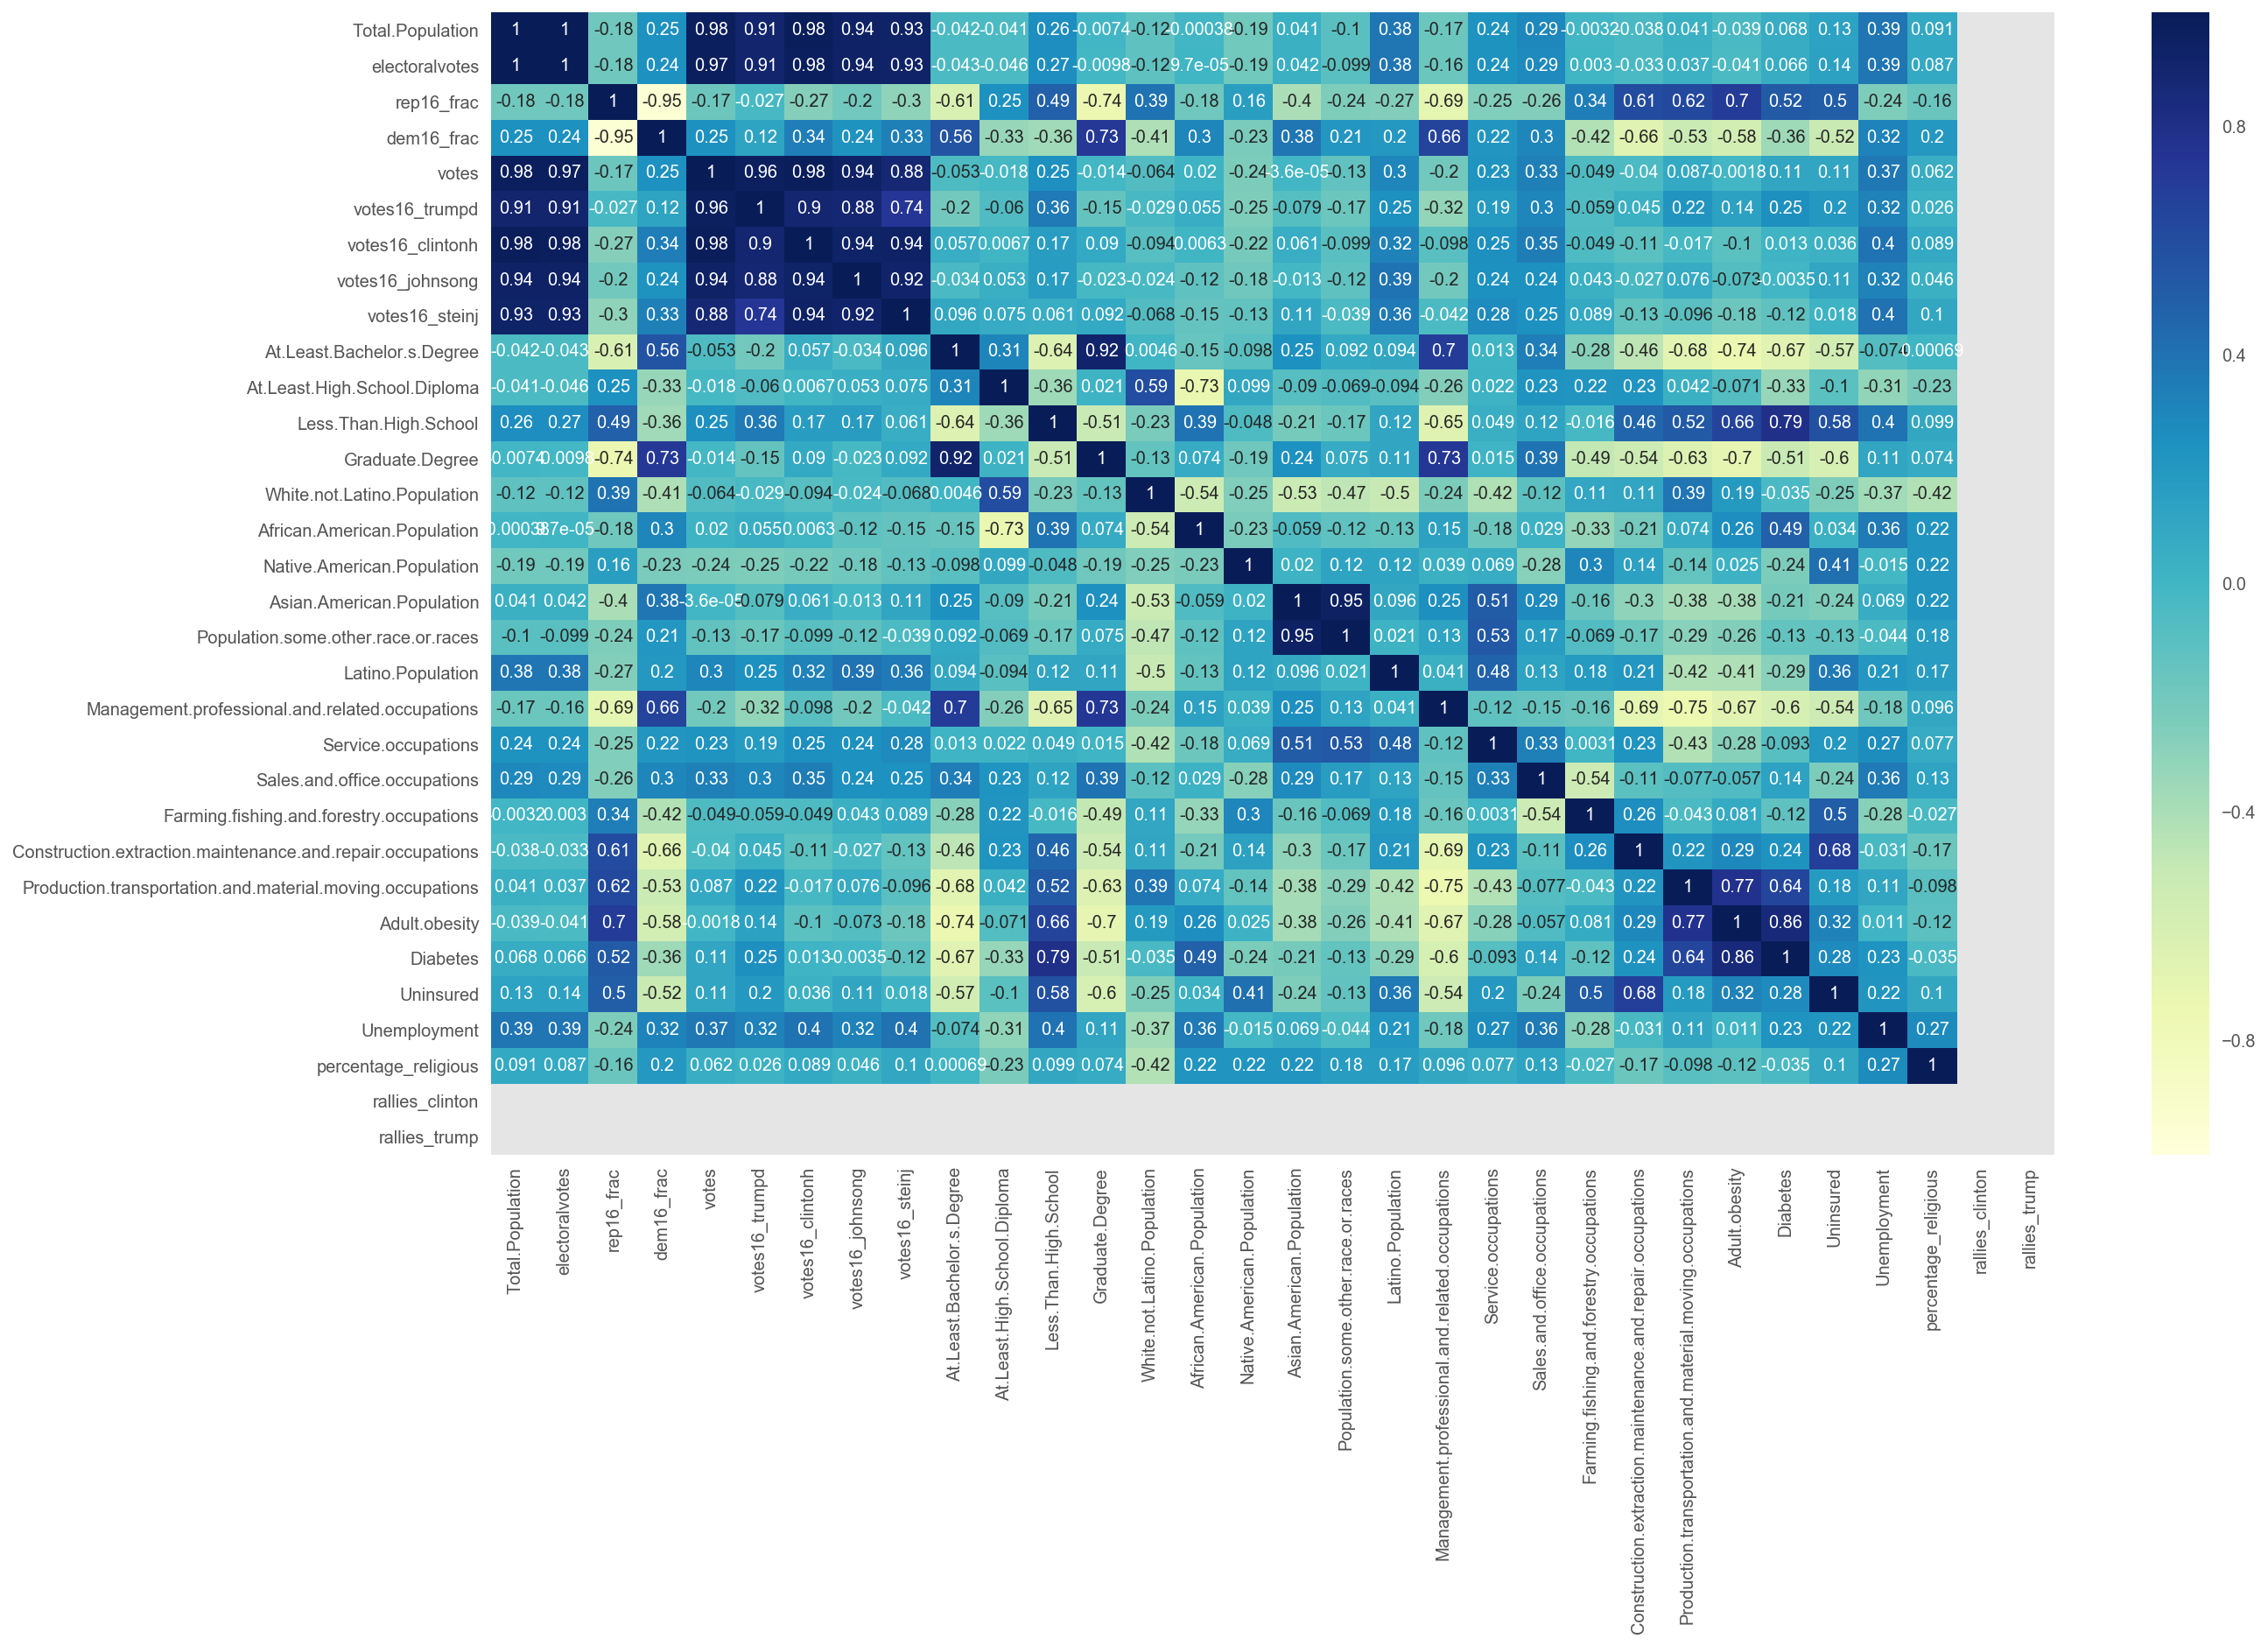

In [242]:
plt.figure(figsize=(20,12))

sns.heatmap(df_merged.corr(), annot=True, cmap='YlGnBu')

# Sentiment Analysis vs. Demographic & Economic Variables

In [1]:
df_tweets_sentiment = pd.read_pickle('../../../../../Downloads/ap_tweets_classified_sentiment.zip')

NameError: name 'pd' is not defined

In [3]:
df_tweets_sentiment = pd.merge(df_tweets_sentiment, pd.get_dummies(df_tweets_sentiment.sentiment), left_index=True, right_index=True)

In [4]:
df_tweets_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584832 entries, 1 to 651062
Data columns (total 38 columns):
tweet_id                 584832 non-null int64
created_at               584832 non-null object
entities_hashtags        584832 non-null object
entities_mentions        584832 non-null object
place_bounding_box       584801 non-null object
country                  584801 non-null object
place_country_code       584801 non-null object
place_full_name          584801 non-null object
place_id                 584801 non-null object
place_name               584801 non-null object
place_place_type         584801 non-null object
place_url                584801 non-null object
favorite_count           584832 non-null int64
geo_coordinates          7094 non-null object
geo_type                 7094 non-null object
text                     584832 non-null object
lang                     584832 non-null object
retweet_count            584832 non-null int64
retweeted                584832 

In [57]:
df_tweets_sentiment_us = df_tweets_sentiment[df_tweets_sentiment.place_country_code == 'US']

In [188]:
df_tweets_sentiment_us['state'] = df_tweets_sentiment_us.place_full_name.apply(lambda x: DSF_helpers.get_state_ABRV(x))

In [237]:
df_hillary = df_tweets_sentiment_us[(df_tweets_sentiment_us.about == 1)]
df_hillary['created_at'] = pd.to_datetime(df_hillary['created_at'])
df_hillary = df_hillary.set_index('created_at')

df_trump = df_tweets_sentiment_us[(df_tweets_sentiment_us.about == 0)]
df_trump['created_at'] = pd.to_datetime(df_trump['created_at'])
df_trump = df_trump.set_index('created_at')

df_time_hillary_pos = df_hillary.resample('D').mean().pos #hillary positive
#df_time_hillary_neu = df_hillary.resample('D').mean().neu #hillary positive
df_time_hillary_neg = df_hillary.resample('D').mean().neg #hillary positive

df_trump_pos = df_trump.resample('D').mean().pos #trump positive
#df_trump_neu = df_trump.resample('D').mean().neu #trump positive
df_trump_neg = df_trump.resample('D').mean().neg #trump positive

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



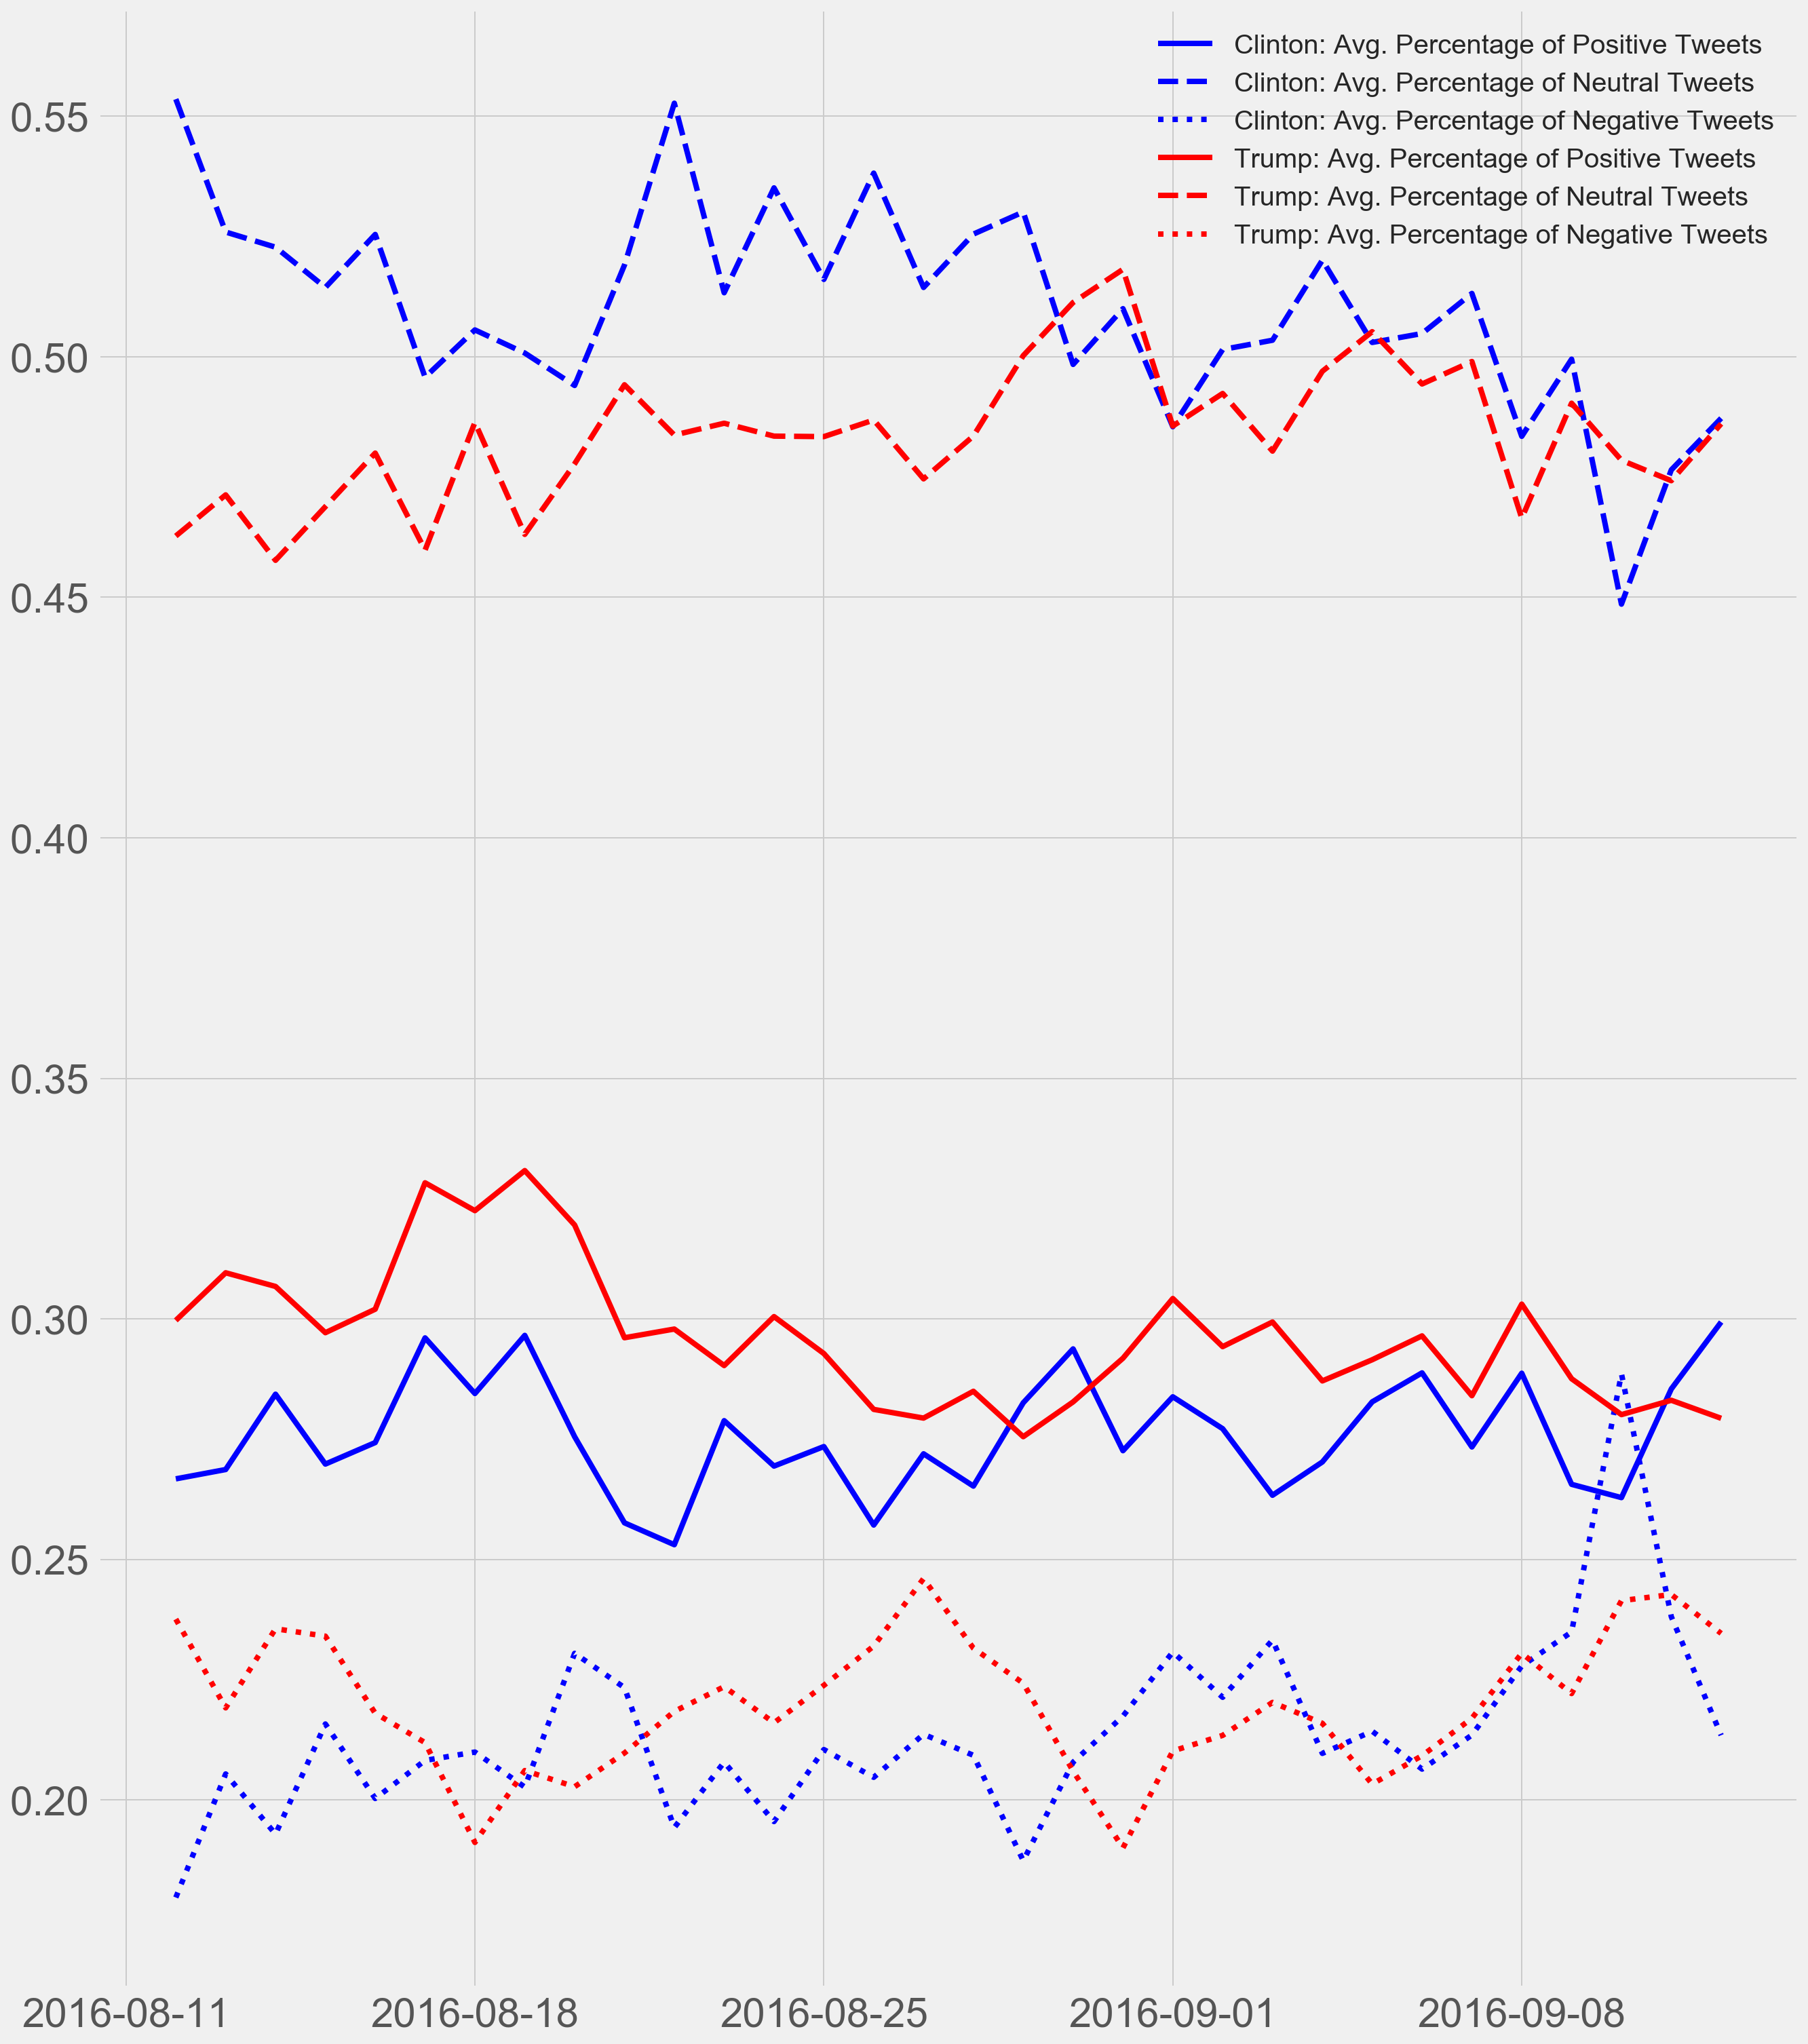

In [51]:
plt.figure(figsize=(20,25))

plt.style.use('fivethirtyeight')

plt.tick_params(labelsize=30)

plt.plot(df_time_hillary_pos, label='Clinton: Avg. Percentage of Positive Tweets', color='blue')
plt.plot(df_time_hillary_neu, '--', label='Clinton: Avg. Percentage of Neutral Tweets', color='blue')
plt.plot(df_time_hillary_neg, ':', label='Clinton: Avg. Percentage of Negative Tweets', color='blue')

plt.plot(df_trump_pos, label='Trump: Avg. Percentage of Positive Tweets', color='red')
plt.plot(df_trump_neu, '--', label='Trump: Avg. Percentage of Neutral Tweets', color='red')
plt.plot(df_trump_neg, ':', label='Trump: Avg. Percentage of Negative Tweets', color='red')

plt.legend(loc=1, prop={'size': 20})

#df_tweets_sentiment_us[(df_tweets_sentiment_us.state.str.len() == 2)].groupby('state').mean()

In [44]:
df_tweets_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 584832 entries, 1 to 651062
Data columns (total 38 columns):
tweet_id                 584832 non-null int64
created_at               584832 non-null object
entities_hashtags        584832 non-null object
entities_mentions        584832 non-null object
place_bounding_box       584801 non-null object
country                  584801 non-null object
place_country_code       584801 non-null object
place_full_name          584801 non-null object
place_id                 584801 non-null object
place_name               584801 non-null object
place_place_type         584801 non-null object
place_url                584801 non-null object
favorite_count           584832 non-null int64
geo_coordinates          7094 non-null object
geo_type                 7094 non-null object
text                     584832 non-null object
lang                     584832 non-null object
retweet_count            584832 non-null int64
retweeted                584832 

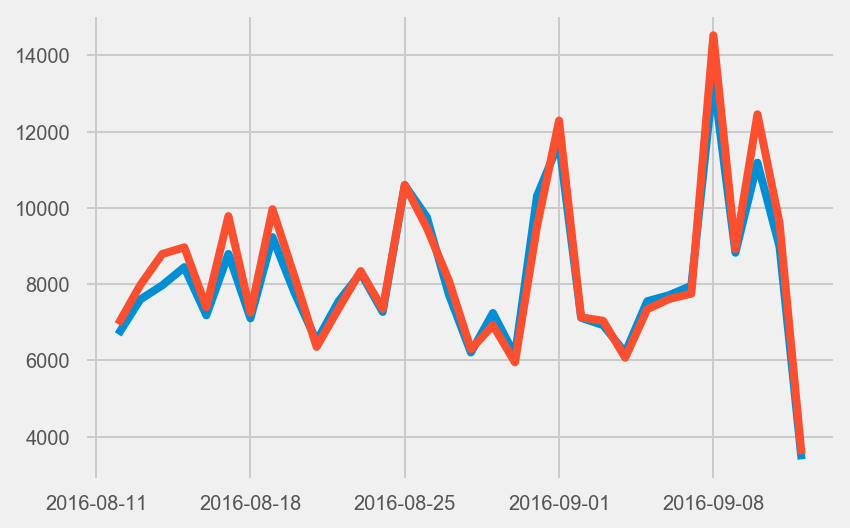

In [84]:
#df_tweets_sentiment_us['created_at'] = pd.to_datetime(df_tweets_sentiment_us['created_at'])
#df_tweets_sentiment_us = df_tweets_sentiment_us.set_index('created_at')

plt.plot((df_tweets_sentiment_us[df_tweets_sentiment_us.sentiment == 'neu']).resample('D').count().neu)
plt.plot((df_tweets_sentiment_us[df_tweets_sentiment_us.sentiment != 'neu']).resample('D').count().neu)

In [245]:
df_tweets_sentiment_us

,tweet_id,created_at,entities_hashtags,entities_mentions,place_bounding_box,country,place_country_code,place_full_name,place_id,place_name,...,user_location,user_screen_name,user_statuses_count,user_time_zone,user_url,user_verified,about,sentiment,pos,neg
1,764039733076897792,Fri Aug 12 10:04:02 +0000 2016,"[([62, 72], NOJUSTICE), ([93, 104], TrumpPence)]","[(813286, 813286, [0, 12], Barack Obama, Barac...","([[[-91.218994, 30.354161], [-91.218994, 30.56...",United States,US,"Baton Rouge, LA",c7ef5f3368b68777,Baton Rouge,...,"Ogletown, DE",redoctapus,5046,Eastern Time (US & Canada),None,False,0.0,neu,0,0
4,764039849850482689,Fri Aug 12 10:04:30 +0000 2016,"[([0, 4], CNN), ([5, 12], newday), ([19, 25], ...",[],"([[[-76.711521, 39.197211], [-76.711521, 39.37...",United States,US,"Baltimore, MD",c0b8e8dc81930292,Baltimore,...,None,bspence5,92605,None,None,False,0.0,pos,1,0
5,764039917924069376,Fri Aug 12 10:04:46 +0000 2016,"[([104, 115], NeverTrump)]","[(25073877, 25073877, [0, 16], Donald J. Trump...","([[[-116.567788, 33.779426], [-116.567788, 33....",United States,US,"Palm Springs, CA",4265ece9285a2872,Palm Springs,...,"Palm Springs, CA",AsaDeMatteo,1154,None,http://asadematteo.tumblr.com,False,0.0,neu,0,0
7,764039926161604608,Fri Aug 12 10:04:48 +0000 2016,[],"[(15693493, 15693493, [109, 120], Funny Or Die...","([[[-74.093886, 40.750391], [-74.093886, 40.80...",United States,US,"Secaucus, NJ",c5e2e95296cb121d,Secaucus,...,"Secaucus, NJ",GinebraFilms,341,Pacific Time (US & Canada),None,False,0.0,pos,1,0
8,764039928116240384,Fri Aug 12 10:04:48 +0000 2016,[],"[(1339835893, 1339835893, [0, 15], Hillary Cli...","([[[-97.034184, 32.771786], [-97.034184, 32.95...",United States,US,"Irving, TX",dce44ec49eb788f5,Irving,...,"Irving, TX",VNDISABLEDVET,698,Central Time (US & Canada),None,False,1.0,neg,0,1
10,764039948567576576,Fri Aug 12 10:04:53 +0000 2016,[],"[(4852163069, 4852163069, [0, 12], Mike, mike4...","([[[-76.5803, 38.644972], [-76.5803, 38.721348...",United States,US,"Chesapeake Beach, MD",faef11a3eaa8abdb,Chesapeake Beach,...,"Maryland, USA",kimseacret3,277,None,http://www.seacretdirect.com/kimwasson,False,0.0,neu,0,0
11,764039975583227904,Fri Aug 12 10:05:00 +0000 2016,[],"[(25073877, 25073877, [0, 16], Donald J. Trump...","([[[-85.313052, 42.232049], [-85.313052, 42.38...",United States,US,"Battle Creek, MI",658096f6d8391ba9,Battle Creek,...,None,Anumbr1,18306,None,None,False,0.0,neg,0,1
12,764039994247819264,Fri Aug 12 10:05:04 +0000 2016,"[([90, 98], 15for15), ([99, 107], TeamGov), ([...","[(1339835893, 1339835893, [12, 27], Hillary Cl...","([[[-85.547145, 38.222927], [-85.547145, 38.27...",United States,US,"Middletown, KY",bf470bba599e2ff8,Middletown,...,"Louisville, KY/Palm Coast, FL",Roboviper,579,Atlantic Time (Canada),None,False,2.0,neu,0,0
13,764040054427619328,Fri Aug 12 10:05:18 +0000 2016,[],"[(317090188, 317090188, [0, 9], Russ Hayden, C...","([[[-90.69214, 41.475836], [-90.69214, 41.6000...",United States,US,"Davenport, IA",9c1c0a45346f5837,Davenport,...,Iowa,TroxelRobert,656,None,None,False,0.0,neu,0,0
15,764040223990779904,Fri Aug 12 10:05:59 +0000 2016,"[([115, 126], NeverTrump), ([128, 134], Crazy)]",[],"([[[-109.060257, 36.992427], [-109.060257, 41....",United States,US,"Colorado, USA",e21c8e4914eef2b3,Colorado,...,None,Brewgan,1151,None,http://www.facebook.com/brewgan,False,0.0,neu,0,0


In [261]:
df_tweets_sentiment_average_trump = df_tweets_sentiment_us[df_tweets_sentiment_us.about == 0].loc[:, ['neg', 'neu', 'pos', 'state']].groupby('state').mean()
df_tweets_sentiment_average_hillary = df_tweets_sentiment_us[df_tweets_sentiment_us.about == 1].loc[:, ['neg', 'neu', 'pos', 'state']].groupby('state').mean()

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning:


Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike



In [267]:
df_merged_final = pd.merge(df_tweets_sentiment_average_trump, df_merged, left_index = True, right_on = 'code')

,neg,neu,pos,State,Region,Total.Population,electoralvotes,rep16_frac,dem16_frac,votes,...,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,code,percentage_religious,rallies_clinton,rallies_trump
1,0.219245,NaN,0.342266,Alaska,West,696686.5,3,0.529000,0.377000,249484,...,11.675862,14.631034,0.298833,0.072625,0.276000,0.094083,AK,0.77,NaN,NaN
0,0.183341,NaN,0.269160,Alabama,South,4706548.0,9,0.629000,0.346000,2078165,...,12.050746,21.281343,0.350821,0.140821,0.174149,0.085701,AL,0.77,NaN,NaN
3,0.208433,NaN,0.308671,Arkansas,South,2877030.5,6,0.681466,0.318534,1121684,...,11.146000,21.049333,0.336160,0.124547,0.209827,0.082240,AR,0.71,NaN,NaN
2,0.205380,NaN,0.315910,Arizona,West,6358441.0,11,0.495000,0.454000,2062810,...,13.316667,10.410000,0.278067,0.100800,0.205333,0.114067,AZ,0.73,NaN,NaN
4,0.235046,NaN,0.290258,California,West,36781241.5,55,0.328000,0.616000,11954317,...,9.853448,10.617241,0.242190,0.080776,0.189552,0.122517,CA,0.70,NaN,NaN
5,0.231675,NaN,0.302033,Colorado,West,4936203.5,9,0.444000,0.472000,2564185,...,13.665625,9.597656,0.206828,0.063062,0.198781,0.075781,CO,0.70,NaN,NaN
6,0.225467,NaN,0.290498,Connecticut,Northeast,3534292.0,7,0.412000,0.545000,1623542,...,8.462500,10.712500,0.243500,0.082875,0.092875,0.081875,CT,0.69,NaN,NaN
8,0.206793,NaN,0.304815,District of Columbia,South,595078.0,3,0.041000,0.928000,280272,...,3.300000,4.650000,0.210000,0.081000,0.083000,0.089000,DC,0.66,NaN,NaN
7,0.216086,NaN,0.304922,Delaware,Northeast,880883.0,3,0.419000,0.534000,441535,...,10.483333,11.483333,0.301333,0.106000,0.116333,0.072000,DE,0.66,NaN,NaN
9,0.205778,NaN,0.301321,Florida,South,18511865.0,29,0.491000,0.478000,9386750,...,12.244776,10.532090,0.297776,0.115985,0.232373,0.086254,FL,0.65,NaN,NaN


In [270]:
df_merged_final = pd.merge(df_tweets_sentiment_average_trump, df_merged, left_index = True, right_on = 'code', suffixes=['_trump', ''])
df_merged_final = pd.merge(df_tweets_sentiment_average_hillary, df_merged_final, left_index=True, right_on='code', suffixes=['_hillary', ''])

In [271]:
df_merged_final = df_merged_final.rename(columns={'neu': 'neu_trump', 'neg': 'neg_trump', 'pos': 'pos_trump'})

In [275]:
df_merged_final = df_merged_final.drop(['rallies_clinton', 'rallies_trump'], axis=1)

In [280]:
df_corr = df_merged_final.corr().iloc[:6].drop(['votes', 'votes16_trumpd', 'votes16_clintonh', 'votes16_johnsong', 'votes16_steinj', 'Adult.obesity', 'percentage_religious'], axis=1)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text yticklabel objects>)

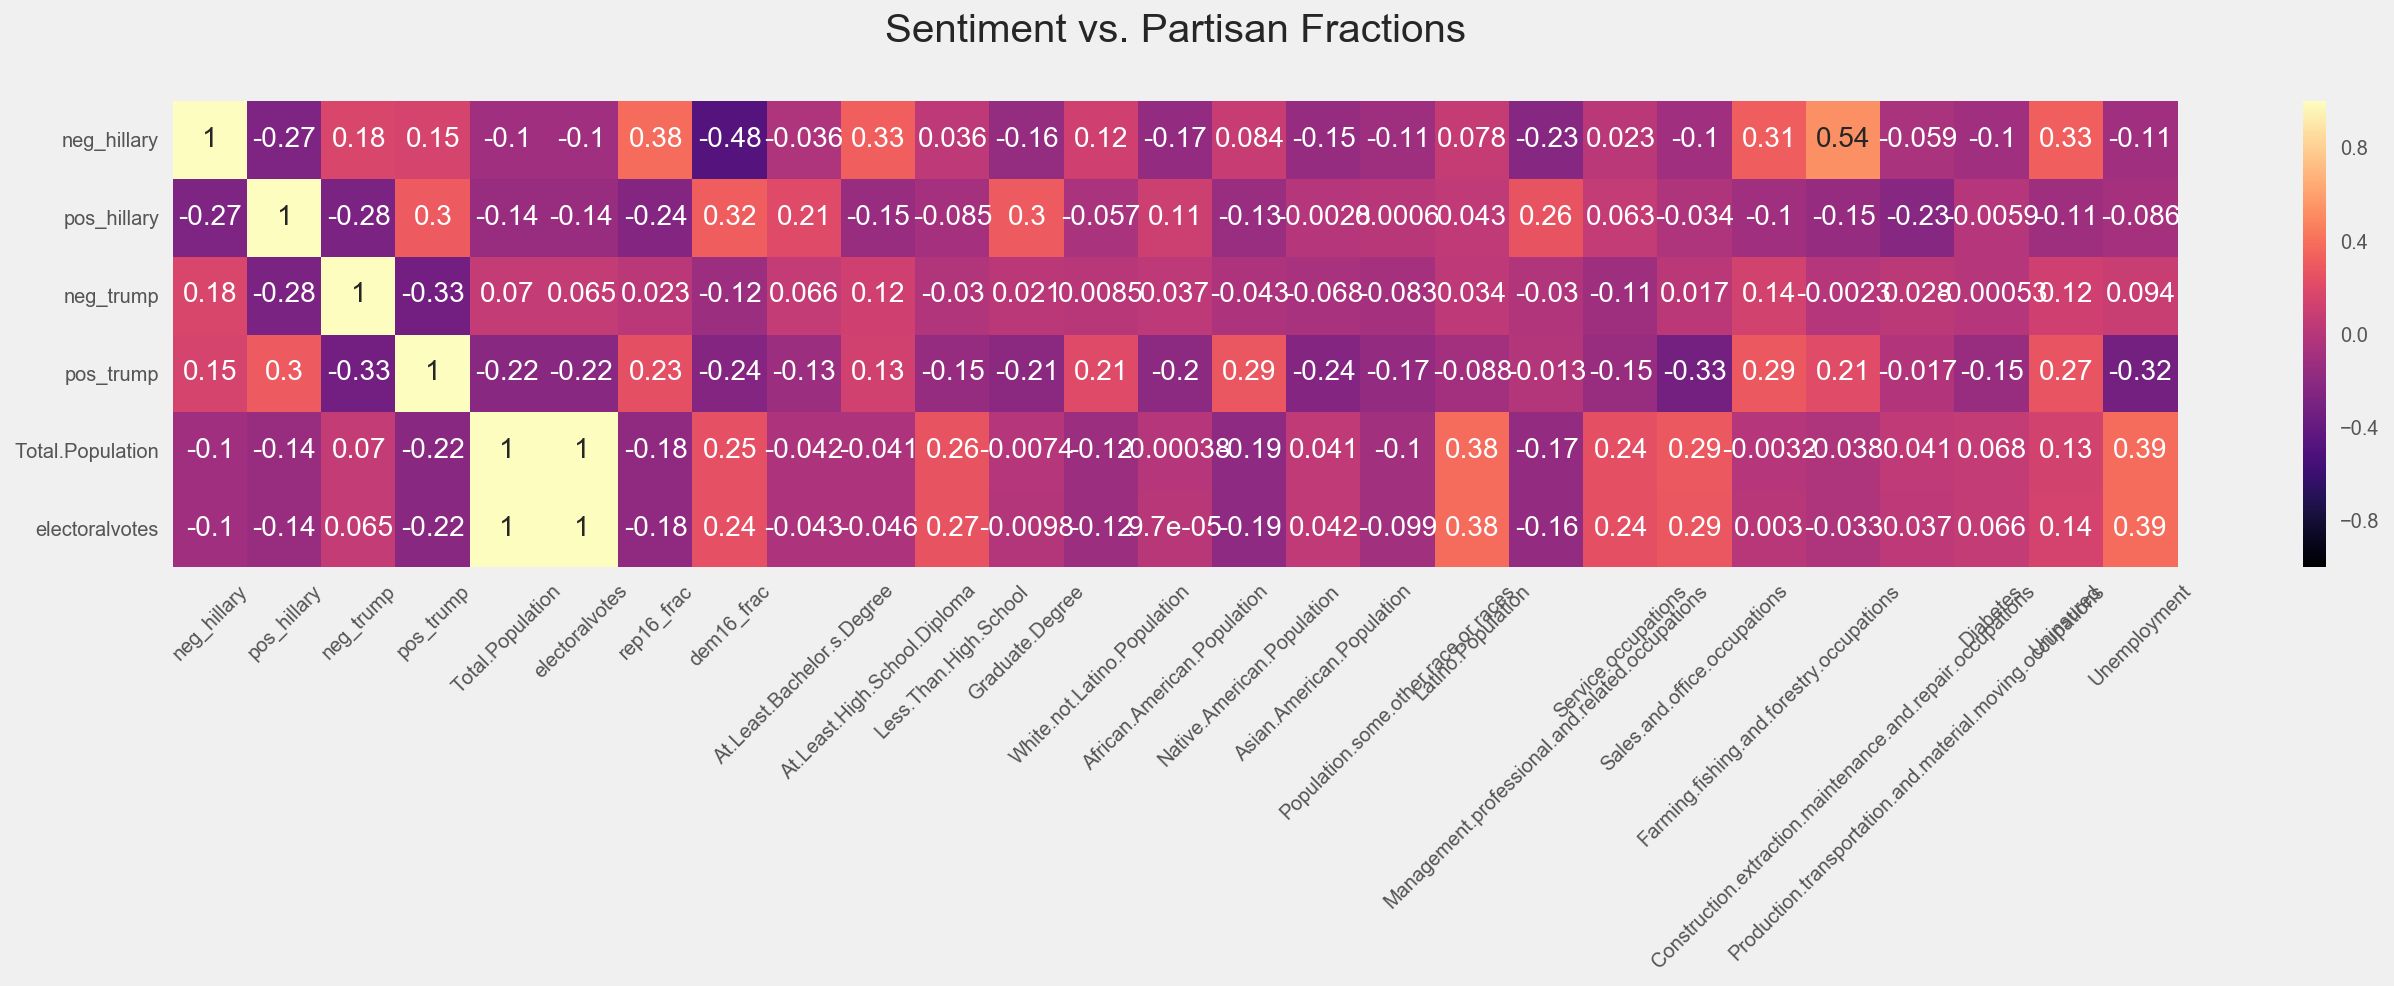

In [317]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(20,4))

plt.title('Sentiment vs. Partisan Fractions', y=1.1)

sns.heatmap(df_corr, annot=True, cmap='magma')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([ 0.5,  1.5]), <a list of 2 Text yticklabel objects>)

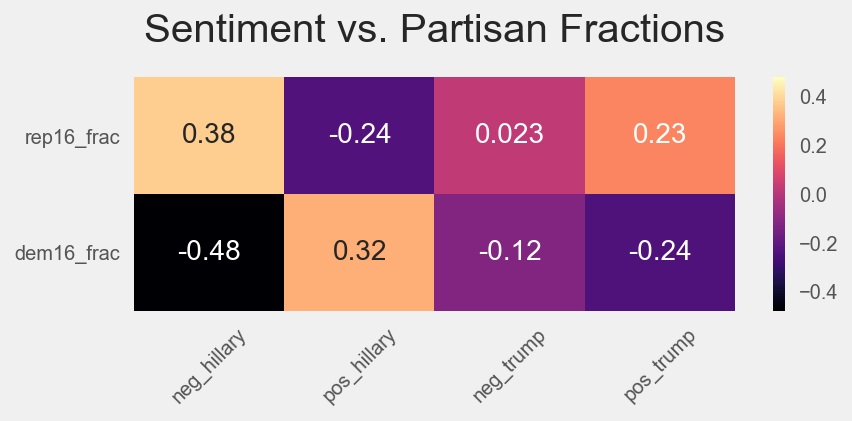

In [333]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(6,2))

plt.title('Sentiment vs. Partisan Fractions', y=1.1)

sns.heatmap(df_corr.iloc[:4,6:8].transpose(), annot=True, cmap='magma')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5]), <a list of 4 Text yticklabel objects>)

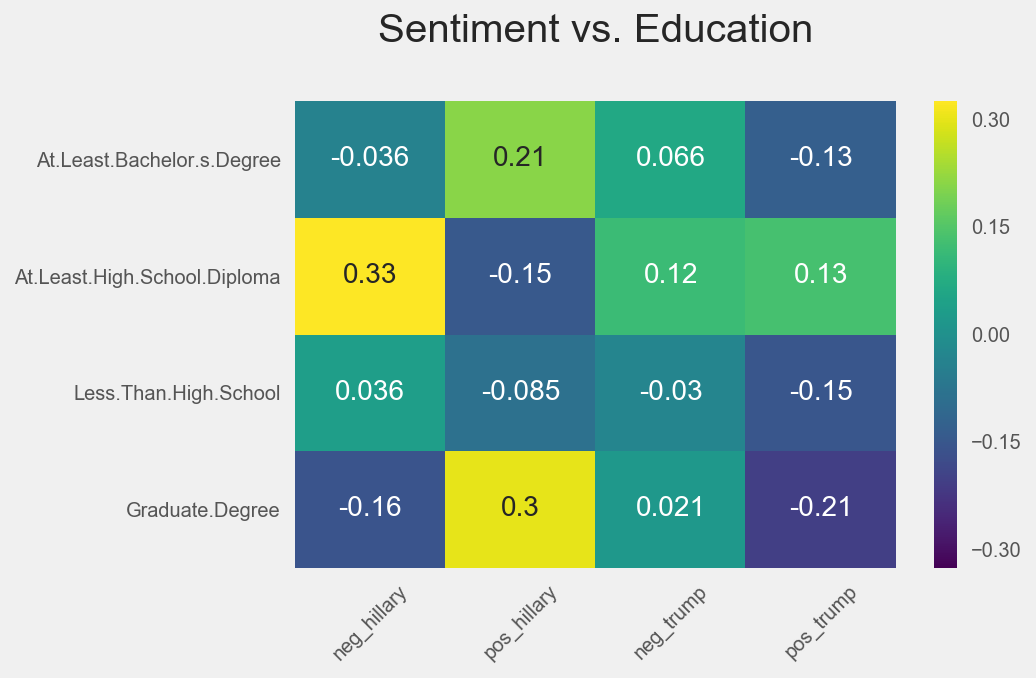

In [334]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(6,4))

plt.title('Sentiment vs. Education', y=1.1)

sns.heatmap(df_corr.iloc[:4,8:12].transpose(), annot=True, cmap='viridis')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text yticklabel objects>)

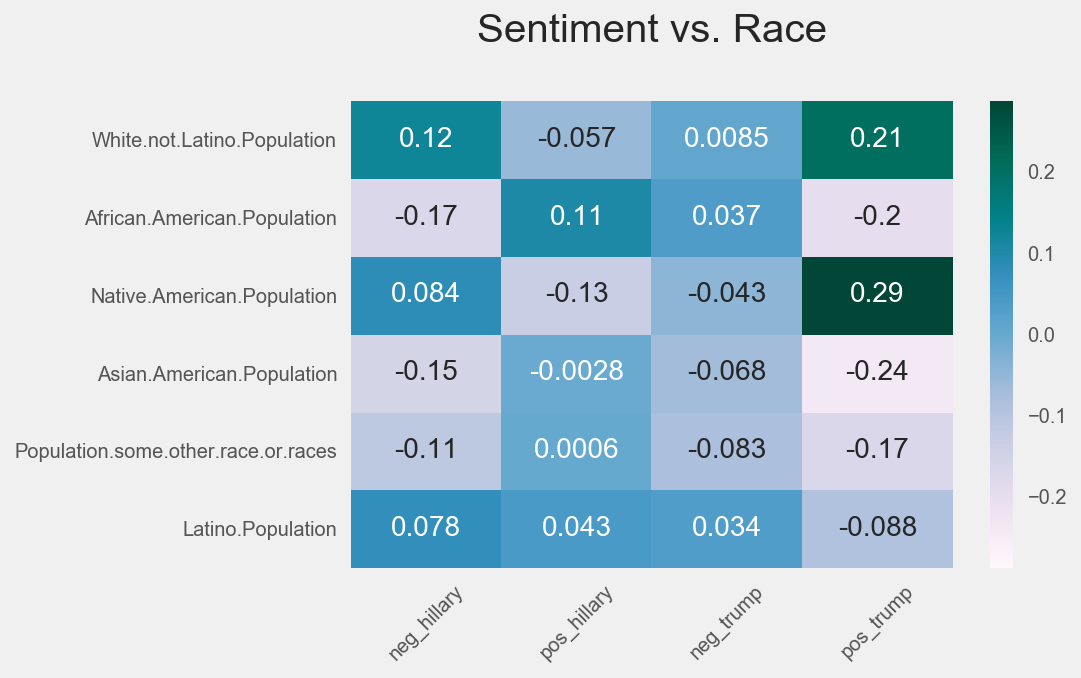

In [336]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(6,4))

plt.title('Sentiment vs. Race', y=1.1)

sns.heatmap(df_corr.iloc[:4,12:18].transpose(), annot=True, cmap='PuBuGn')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5]),
 <a list of 6 Text yticklabel objects>)

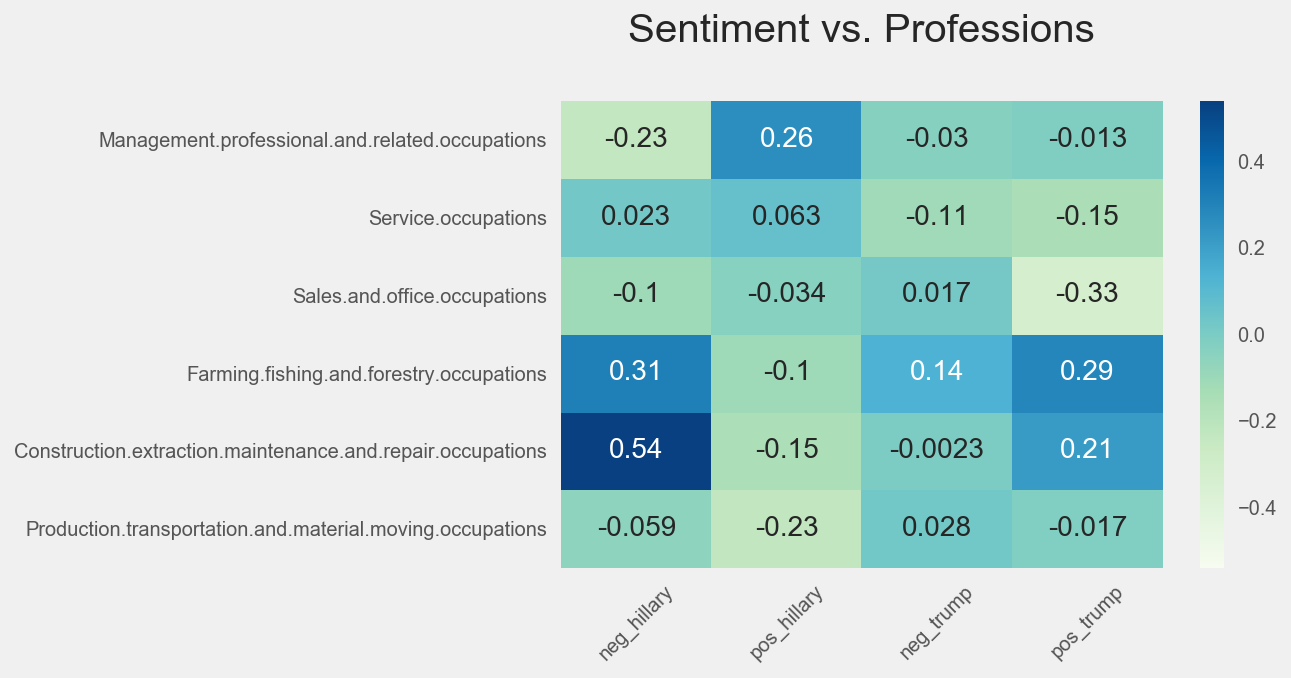

In [337]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(6,4))

plt.title('Sentiment vs. Professions', y=1.1)

sns.heatmap(df_corr.iloc[:4,18:24].transpose(), annot=True, cmap='GnBu')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

(array([ 0.5,  1.5]), <a list of 2 Text yticklabel objects>)

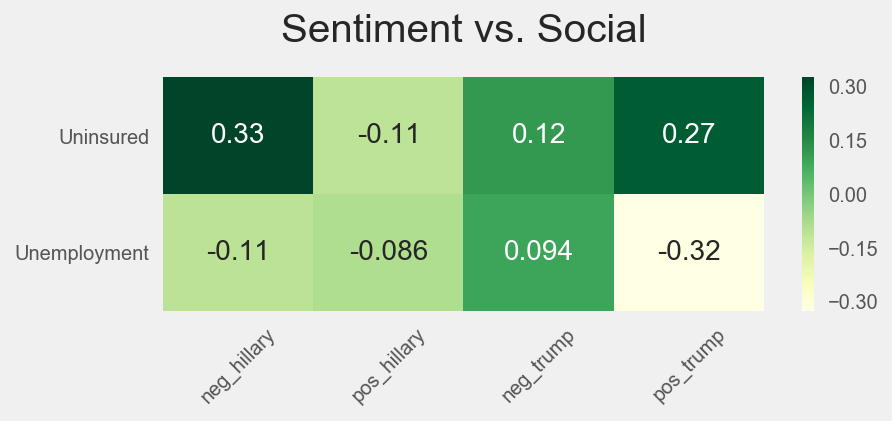

In [339]:
plt.style.use('fivethirtyeight')

plt.figure(figsize=(6,2))

plt.title('Sentiment vs. Social', y=1.1)

sns.heatmap(df_corr.iloc[:4,25:].transpose(), annot=True, cmap='YlGn')

plt.xticks(rotation=45)
plt.yticks(rotation=0)

In [ ]:
programmers = ['Alex','Nicole','Sara','Etienne','Chelsea','Jody','Marianne']

base = datetime.datetime.today()
date_list = [base - datetime.timedelta(days=x) for x in range(0, 180)]

z = []

for prgmr in programmers:
    new_row = []
    for date in date_list:
        new_row.append( np.random.poisson() )
    z.append(list(new_row))

data = [
    go.Heatmap(
        z=z,
        x=date_list,
        y=programmers,
        colorscale='Viridis',
    )
]

layout = go.Layout(
    title='GitHub commits per day',
    xaxis = dict(ticks='', nticks=36),
    yaxis = dict(ticks='' )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='datetime-heatmap')

In [93]:
df_merged_final.corr()[:6]

,neg_hillary,neu_hillary,pos_hillary,neg_trump,neu_trump,pos_trumo,Total.Population,electoralvotes,rep16_frac,dem16_frac,...,Farming.fishing.and.forestry.occupations,Construction.extraction.maintenance.and.repair.occupations,Production.transportation.and.material.moving.occupations,Adult.obesity,Diabetes,Uninsured,Unemployment,percentage_religious,rallies_clinton,rallies_trump
neg_hillary,1.000000,-0.638841,-0.268359,0.176087,-0.283023,0.153806,-0.101968,-0.102881,0.379576,-0.478377,...,0.313863,0.538694,-0.058752,-0.033735,-0.102741,0.325893,-0.108928,-0.107131,-0.086542,-0.070806
neu_hillary,-0.638841,1.000000,-0.569679,0.074958,0.276494,-0.370006,0.200523,0.202185,-0.135349,0.155028,...,-0.184030,-0.340042,0.232012,0.126701,0.092370,-0.189364,0.161256,0.055469,0.142489,-0.024809
pos_hillary,-0.268359,-0.569679,1.000000,-0.281968,-0.043862,0.298992,-0.142153,-0.143259,-0.236016,0.316923,...,-0.104861,-0.149694,-0.227749,-0.122610,-0.005904,-0.111034,-0.085550,0.044991,-0.085965,0.106705
neg_trump,0.176087,0.074958,-0.281968,1.000000,-0.509731,-0.330554,0.070250,0.064814,0.023284,-0.121041,...,0.136652,-0.002330,0.028007,0.035559,-0.000527,0.119059,0.093543,-0.065610,-0.127616,-0.195139
neu_trump,-0.283023,0.276494,-0.043862,-0.509731,1.000000,-0.643478,0.140844,0.146417,-0.232733,0.317365,...,-0.376900,-0.193835,-0.006793,-0.034148,0.133875,-0.343997,0.218853,0.065151,0.081164,0.009205
pos_trumo,0.153806,-0.370006,0.298992,-0.330554,-0.643478,1.000000,-0.217009,-0.218287,0.234591,-0.240456,...,0.291877,0.214709,-0.017467,0.005823,-0.146393,0.271434,-0.323310,-0.013096,0.024507,0.163523


In [280]:
df_trump = df_trump.reset_index()
df_hillary = df_hillary.reset_index()

In [325]:
df_trump_rallies.date.unique()

array(['2016-09-01T00:00:00.000000000', '2016-09-03T00:00:00.000000000',
       '2016-09-06T00:00:00.000000000', '2016-09-07T00:00:00.000000000',
       '2016-09-09T00:00:00.000000000', '2016-09-12T00:00:00.000000000',
       '2016-09-13T00:00:00.000000000', '2016-09-14T00:00:00.000000000',
       '2016-09-15T00:00:00.000000000', '2016-09-16T00:00:00.000000000',
       '2016-09-17T00:00:00.000000000', '2016-09-19T00:00:00.000000000',
       '2016-09-20T00:00:00.000000000', '2016-09-21T00:00:00.000000000',
       '2016-09-22T00:00:00.000000000', '2016-09-24T00:00:00.000000000',
       '2016-09-26T00:00:00.000000000', '2016-09-27T00:00:00.000000000',
       '2016-09-28T00:00:00.000000000', '2016-09-29T00:00:00.000000000',
       '2016-09-30T00:00:00.000000000'], dtype='datetime64[ns]')

In [196]:
date1 = pd.to_datetime('2016-09-13')
date2 = pd.to_datetime('2016-09-14')

In [197]:
df_aux_trump_pos = df_trump[(df_trump.created_at <= date2) & (df_trump.created_at >= date1)].groupby('state').mean().pos
df_aux_trump_neg = df_trump[(df_trump.created_at <= date2) & (df_trump.created_at >= date1)].groupby('state').mean().neg

df_aux_clinton_pos = df_hillary[(df_hillary.created_at <= date2) & (df_hillary.created_at >= date1)].groupby('state').mean().pos
df_aux_clinton_neg = df_hillary[(df_hillary.created_at <= date2) & (df_hillary.created_at >= date1)].groupby('state').mean().neg

#df_aux_trump_pos = df_aux_trump_pos[(df_aux_trump_pos.values > 0) & (df_aux_trump_pos.values < 1)]
#df_aux_clinton_pos = df_aux_clinton_pos[(df_aux_clinton_pos.values > 0) & (df_aux_clinton_pos.values < 1)]

In [198]:
scl = 'Blues'

data = [ dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale = False,
        locations = df_aux_clinton_pos.index,
        z = df_aux_clinton_pos.values,
        locationmode = 'USA-states',
        text = df_aux_clinton_pos.index,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) )#,
        #colorbar = dict(
        #    title = "% Religious")
        ) ]

layout = dict(
        #title = 'Average Sentiment Score Towards Clinton',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

import plotly.io as pio

pio.write_image(fig, 'clinton{}-{}.png'.format(date1.date(), date2.date()), scale=2)

In [199]:
scl = 'Reds'

data = [ dict(
        type='choropleth',
        colorscale=scl,
        autocolorscale = False,
        locations = df_aux_clinton_pos.index,
        z = df_aux_trump_pos.values,
        locationmode = 'USA-states',
        text = df_aux_clinton_pos.index,
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) )#,
        #colorbar = dict(
        #    title = "% Religious")
        ) ]

layout = dict(
        #title = 'Average Sentiment Score Towards Trump',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
iplot( fig, filename='d3-cloropleth-map' )

pio.write_image(fig, 'trump{}-{}.png'.format(date1.date(), date2.date()), scale=2)